# Over dit document
In dit document wordt een CRISP-DM cycles doorlopen, welke vervolgens een dataproduct (visualisaties) op zal leveren. Tot slot wordt er een conclusie getrokken en advies gegeven.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Business understanding
Het ziekenhuis Isala wil de zorg voor diabetespatiënten verbeteren. Het gaat hier specifiek om het behandelproces door onnauwkeurigheden in metingen te filteren en hierop te baseren of een behandelplan aangepast moet worden of niet. Visualisaties zullen helpen bij het verkrijgen van inzicht van diverse meetmethoden om vervolgens conclusies te kunnen trekken. Die zijn er nog niet. Daarbij zou een visualisatie van een voorspelling meer inzicht brengen in hoe de CV mogelijk zal veranderen per jaar. Dit zou kunnen resulteren in toekomstige plannen voor het standaardiseren van de HbA1c meetmethoden.

Om een voorspelling te realiseren & visualiseren wordt een liniare regressie gebruikt. Hier wordt gekeken naar alle data punten die beschikbaar zijn door de jaren heen en maakt hier een set van data die voorspellend is voor het volgend jaartal.

# Data understanding
Welke databronnen zijn gegeven en in welk formaat:
Een excel bestand genaamd: Complete-dataset-FINAL.xlsx
##### note
Het excel bestand dat gebruikt gaat worden, is het resultaat van rapporten die om zijn gezet naar excel. Dit is de meest recente versie waarin de meetmethoden zijn genormaliseerd en de waarden dubbelgecheckt zijn.

Hoe groot zijn deze databronnen:
355 kB

-4685 rijen

-12 kolommen


Kolomnamen: Method name, N (no. labs), Mean, Bias, CV, Sample, Reference value, Year, Source, Type, Manufacturer (fabrikant).

# Data preparation
De dataset wordt aangepast, zodat het bruikbaar is om tijdsreeksen mee te kunnen voorspellen. We focussen in dit notebook op de CAP source data.

In [2]:
df = pd.read_excel('Complete-dataset-FINAL.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4684 entries, 0 to 4683
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Method name          4684 non-null   object 
 1   N (no. labs)         4684 non-null   object 
 2   Mean                 4602 non-null   float64
 3   Bias                 4058 non-null   float64
 4   CV                   4584 non-null   float64
 5   Sample               4684 non-null   object 
 6   Reference Value      4656 non-null   float64
 7   Year                 4684 non-null   int64  
 8   Source (CAP/EurA1c)  4684 non-null   object 
 9   Type (Fresh/frozen)  4684 non-null   object 
 10  Manufacturer         4684 non-null   object 
 11  Total Error          4684 non-null   float64
dtypes: float64(5), int64(1), object(6)
memory usage: 439.2+ KB


In [3]:
df.head()

,Method name,N (no. labs),Mean,Bias,CV,Sample,Reference Value,Year,Source (CAP/EurA1c),Type (Fresh/frozen),Manufacturer,Total Error
0,Vitros 5.1 FS. 4600. 5600,183,6.14,-0.16,2.3,GH2-04,6.3,2011,CAP,Fresh,Vitros,4.348
1,Vitros 5.1 FS. 4600. 5600,183,7.59,-0.01,2.5,GH2-05,7.6,2011,CAP,Fresh,Vitros,4.890
2,Vitros 5.1 FS. 4600. 5600,183,9.42,0.22,3.0,GH2-06,9.2,2011,CAP,Fresh,Vitros,6.100
3,Vitros 5.1 FS. 4600. 5600,210,5.42,-0.18,2.3,GH2-01,5.6,2012,CAP,Fresh,Vitros,4.328
4,Vitros 5.1 FS. 4600. 5600,210,9.34,-0.06,2.6,GH2-02,9.4,2012,CAP,Fresh,Vitros,5.036


In [4]:
# Groupby Method name
manufacturer = df.dropna().groupby('Manufacturer')
# order manufacturer by size
manufacturerSizes = manufacturer.size().sort_values(ascending=False)
# Only show top more then 100 size
manufacturerSizes = manufacturerSizes[manufacturerSizes > 100]
# Make a new dataframe with the top manufacturers from df
df_manufacturer = df[df['Manufacturer'].isin(manufacturerSizes.index)]
df_manufacturer = df_manufacturer[df_manufacturer['Source (CAP/EurA1c)'] == 'CAP']
df_manufacturer

,Method name,N (no. labs),Mean,Bias,CV,Sample,Reference Value,Year,Source (CAP/EurA1c),Type (Fresh/frozen),Manufacturer,Total Error
0,Vitros 5.1 FS. 4600. 5600,183,6.14,-0.16,2.3,GH2-04,6.30,2011,CAP,Fresh,Vitros,4.348
1,Vitros 5.1 FS. 4600. 5600,183,7.59,-0.01,2.5,GH2-05,7.60,2011,CAP,Fresh,Vitros,4.890
2,Vitros 5.1 FS. 4600. 5600,183,9.42,0.22,3.0,GH2-06,9.20,2011,CAP,Fresh,Vitros,6.100
3,Vitros 5.1 FS. 4600. 5600,210,5.42,-0.18,2.3,GH2-01,5.60,2012,CAP,Fresh,Vitros,4.328
4,Vitros 5.1 FS. 4600. 5600,210,9.34,-0.06,2.6,GH2-02,9.40,2012,CAP,Fresh,Vitros,5.036
...,...,...,...,...,...,...,...,...,...,...,...,...
4679,Vitros 5.1 FS/4600/5600/XT7600 Chem. Systems,204,9.08,0.22,3.1,GH5-01,8.86,2021,CAP,Fresh,Vitros,6.296
4680,Vitros 5.1 FS/4600/5600/XT7600 Chem. Systems,204,6.86,0.02,2.6,GH5-02,6.84,2021,CAP,Fresh,Vitros,5.116
4681,Vitros 5.1 FS/4600/5600/XT7600 Chem. Systems,204,9.40,0.01,3.4,GH5-03,9.39,2021,CAP,Fresh,Vitros,6.674
4682,Vitros 5.1 FS/4600/5600/XT7600 Chem. Systems,204,6.14,0.01,2.5,GH5-04,6.13,2021,CAP,Fresh,Vitros,4.910


# Modeling
---
### CAP CV gemiddelde per jaar per merk

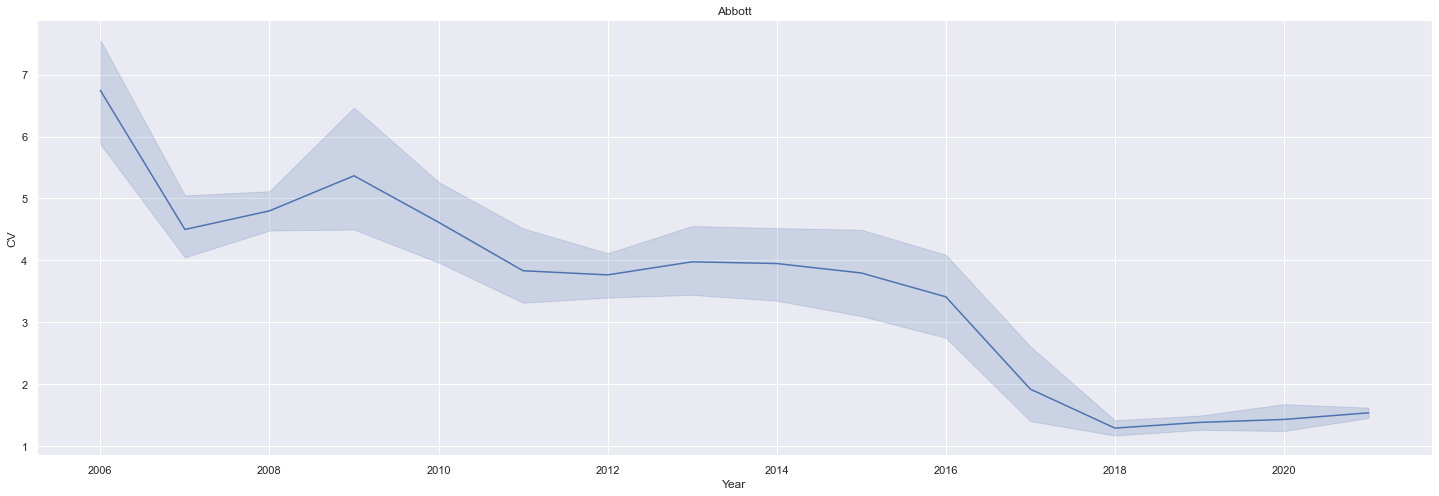

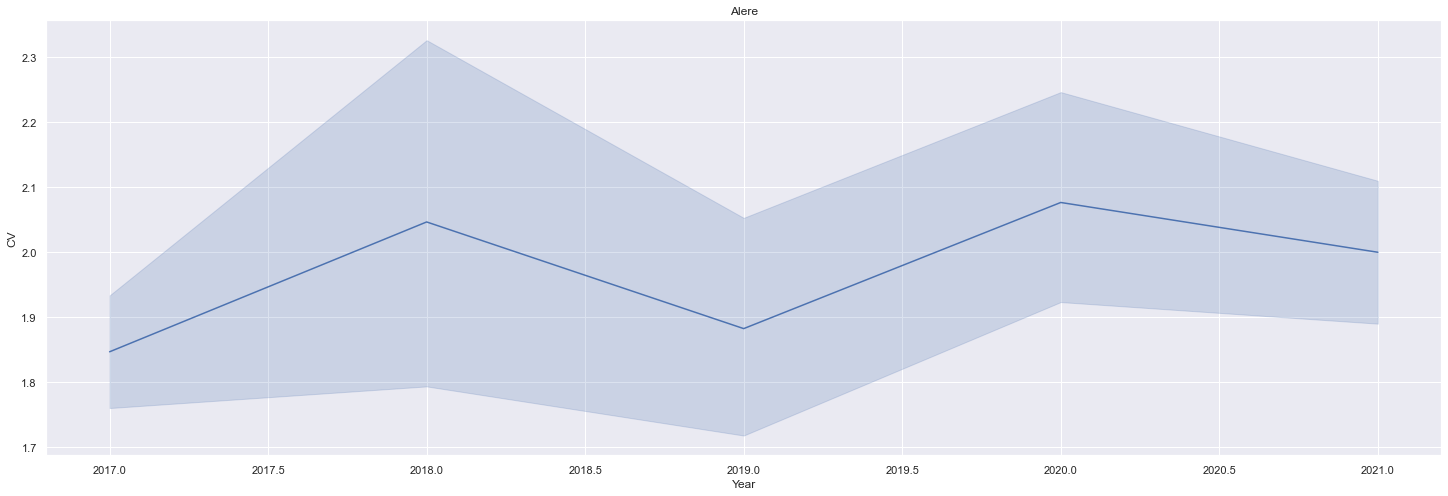

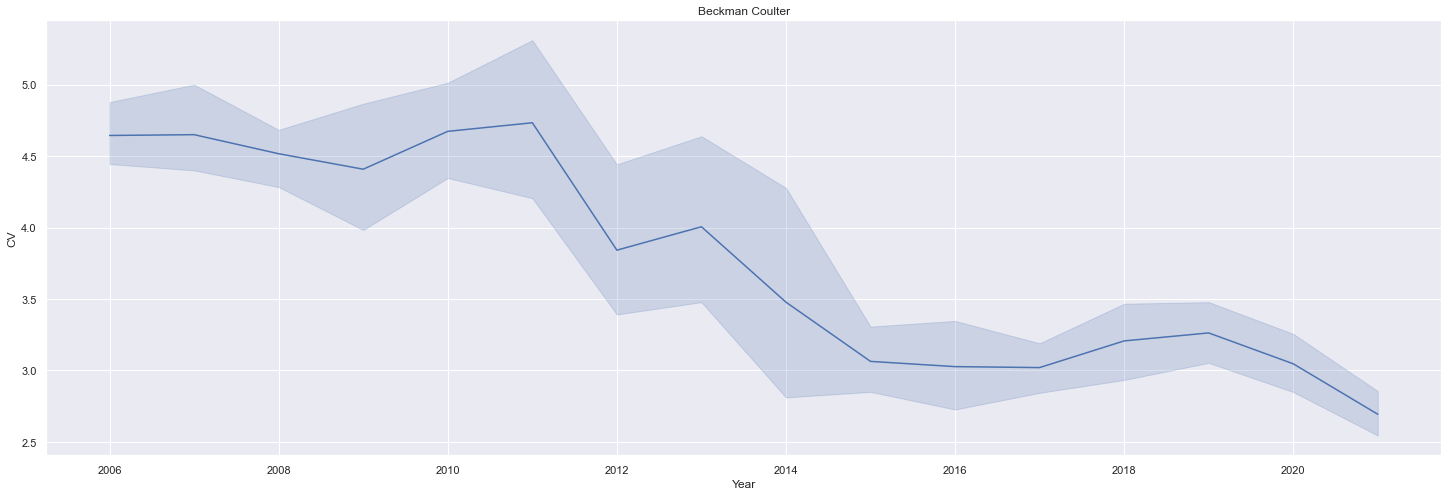

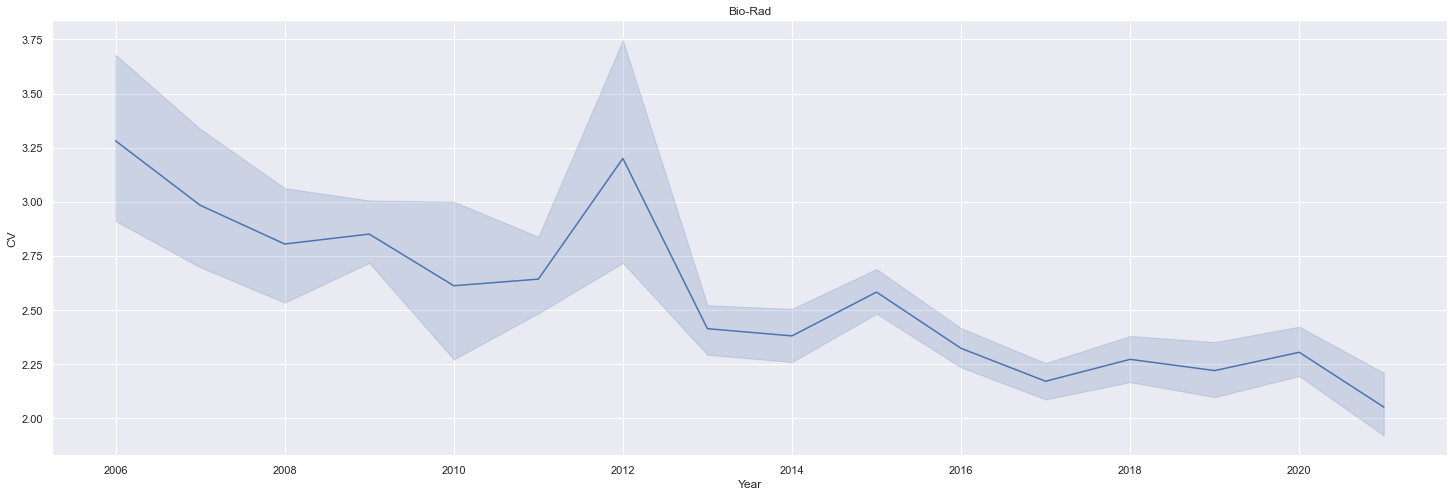

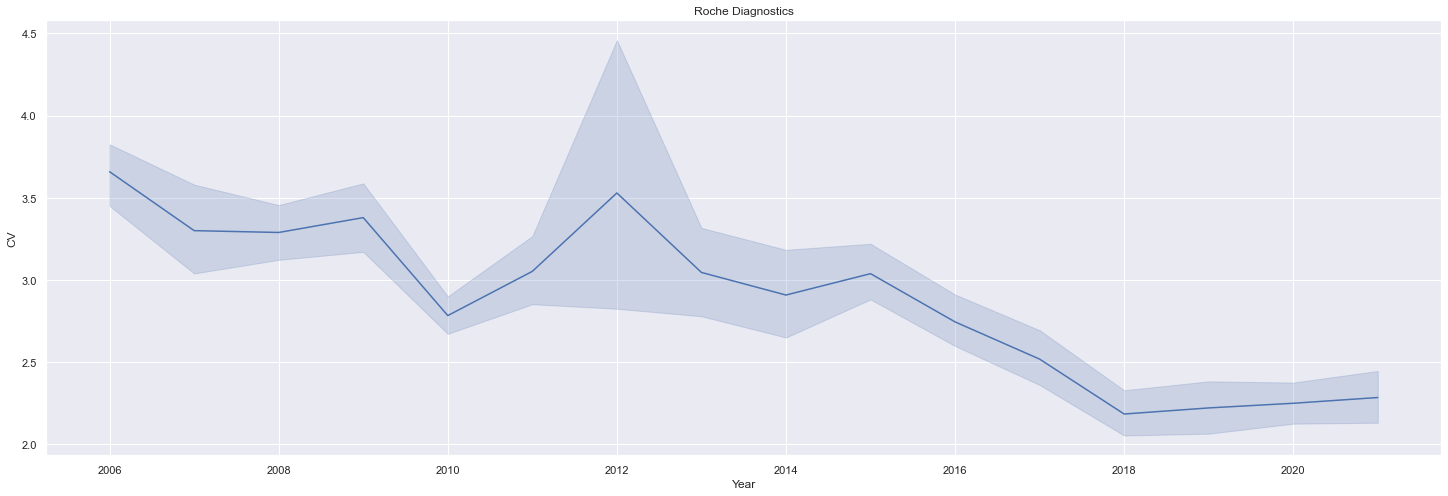

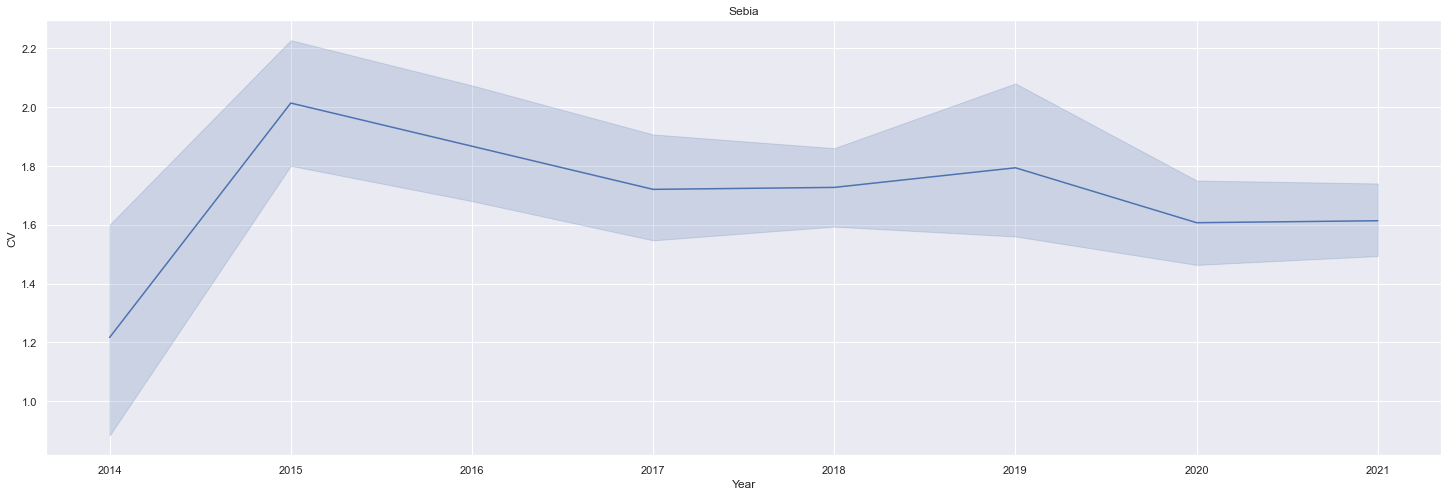

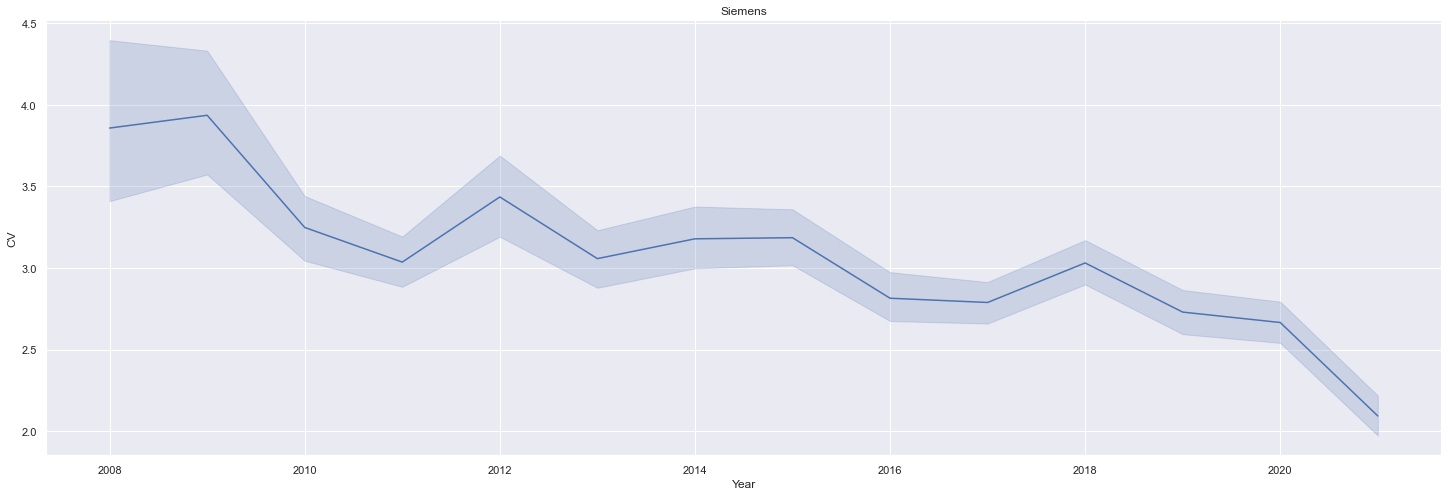

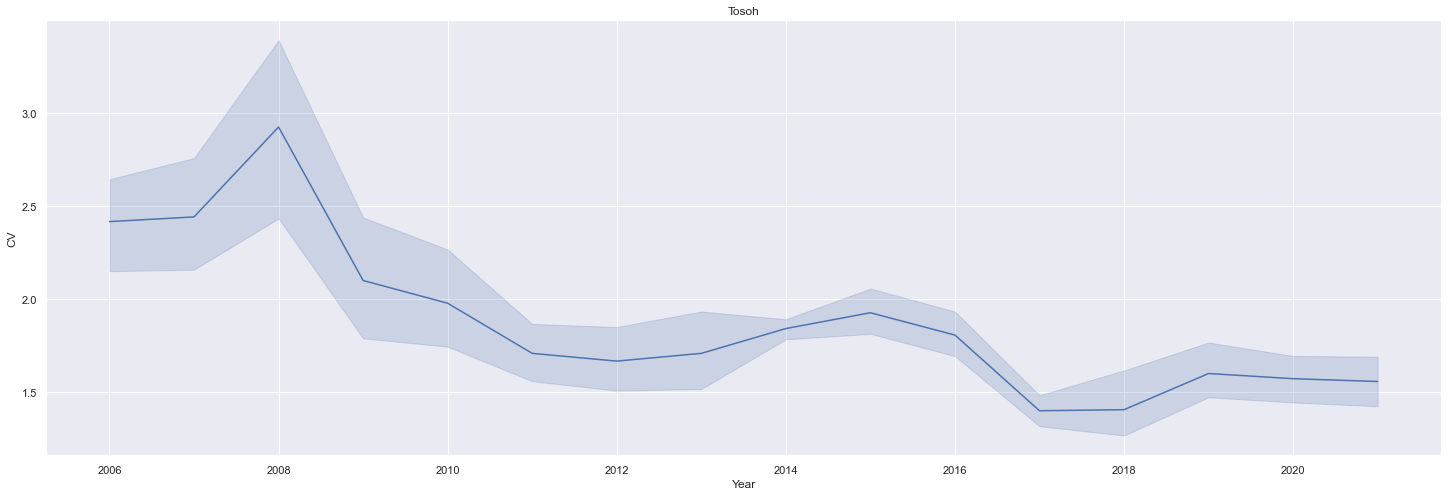

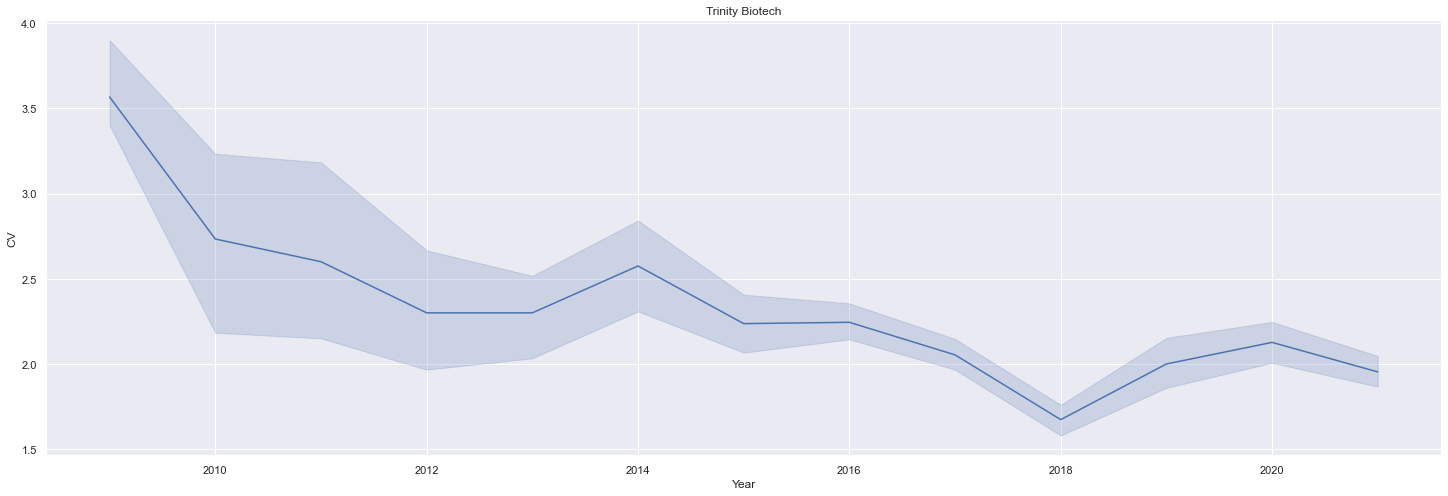

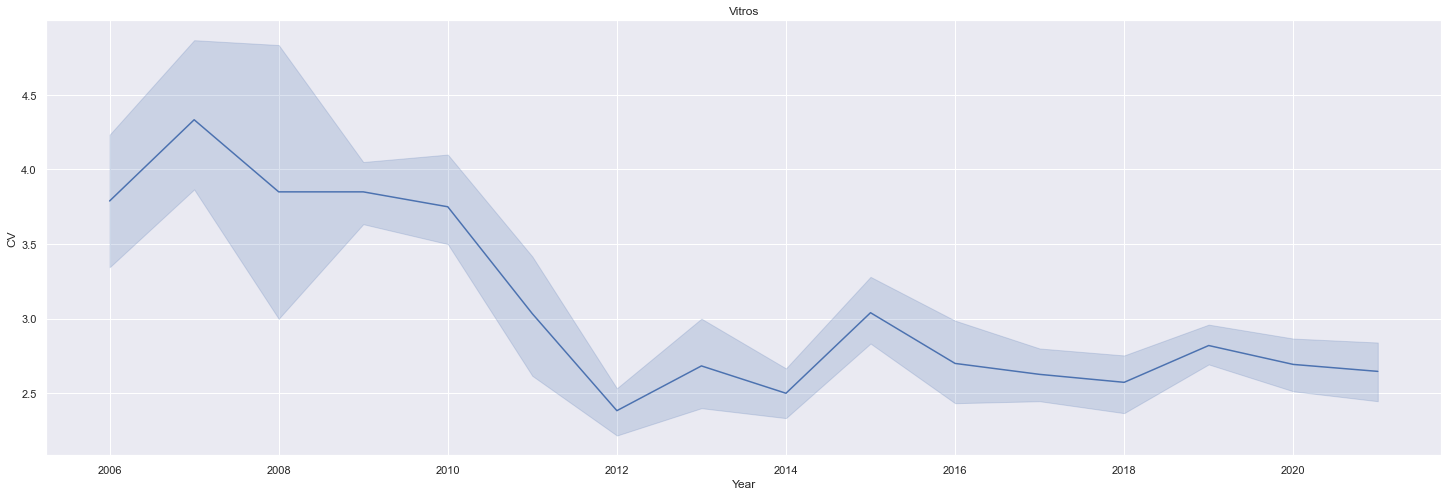

In [7]:
manufacturerGroups = df_manufacturer.groupby('Manufacturer')
# loop manufacturerGroups
for name, data in manufacturerGroups:
    # line plot for CV with seaborn
    sns.set(rc = {'figure.figsize':(25,8)})
    l = sns.lineplot(x='Year', y='CV', data=data)
    l.set_title(name)
    plt.show()
    

### CAP CV gemiddelde per jaar per merk met voorspelling 2022 m.b.v liniare regressie

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.826
Model:                            OLS   Adj. R-squared (uncentered):              0.824
Method:                 Least Squares   F-statistic:                              366.6
Date:                Wed, 25 May 2022   Prob (F-statistic):                    5.22e-31
Time:                        14:35:58   Log-Likelihood:                         -136.74
No. Observations:                  78   AIC:                                      275.5
Df Residuals:                      77   BIC:                                      277.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

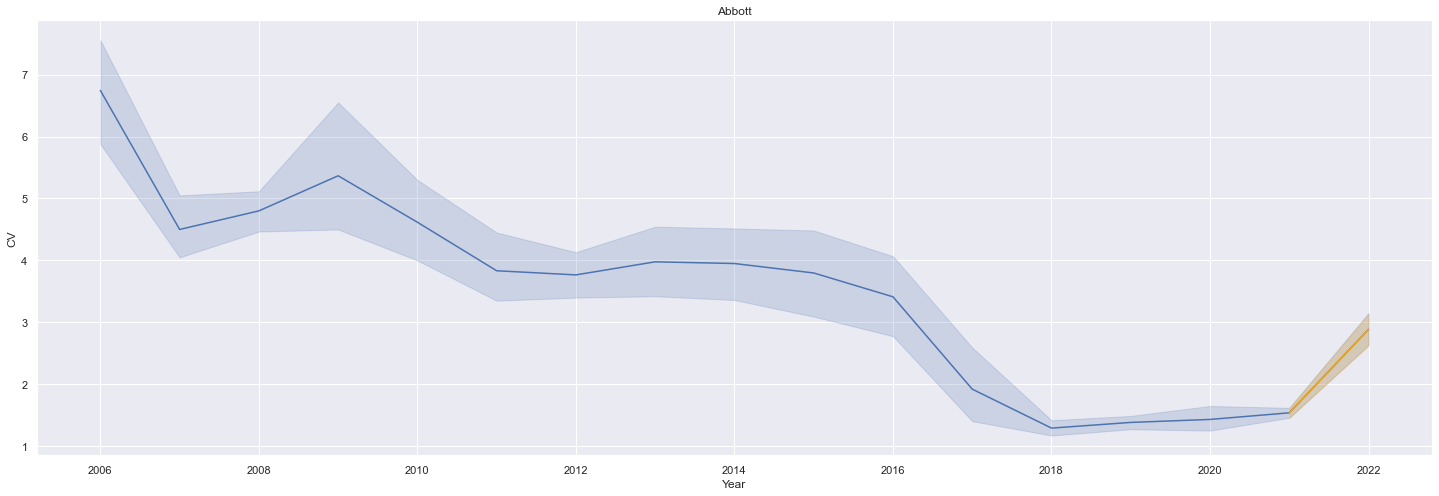

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                              1047.
Date:                Wed, 25 May 2022   Prob (F-statistic):                    5.09e-26
Time:                        14:35:59   Log-Likelihood:                         -12.449
No. Observations:                  33   AIC:                                      26.90
Df Residuals:                      32   BIC:                                      28.39
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

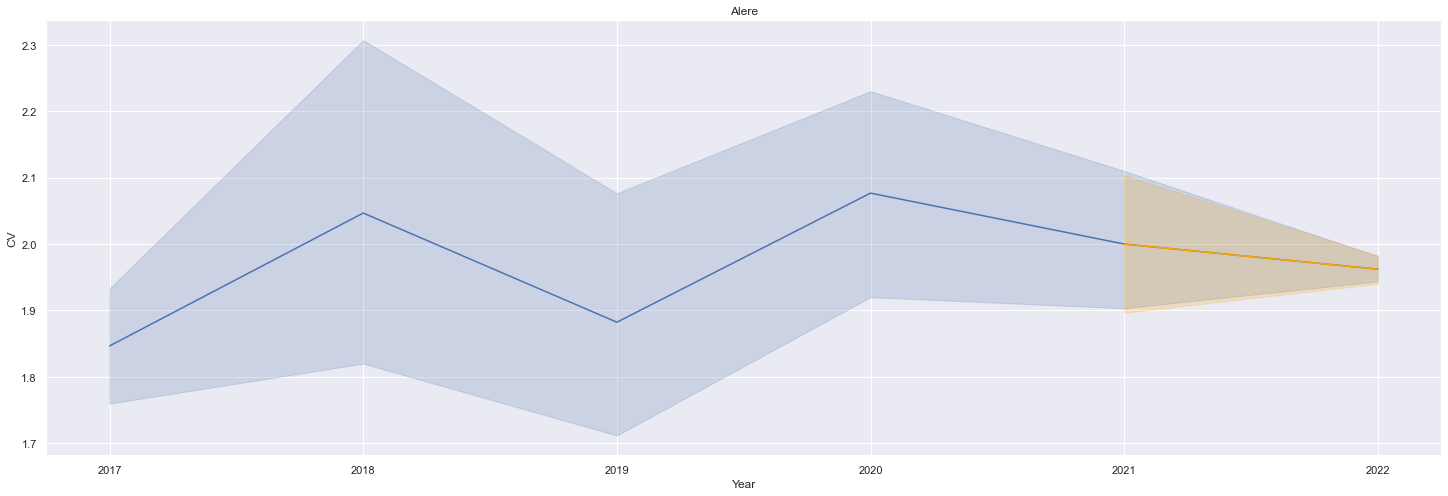

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              1960.
Date:                Wed, 25 May 2022   Prob (F-statistic):                    7.40e-69
Time:                        14:35:59   Log-Likelihood:                         -126.51
No. Observations:                 104   AIC:                                      255.0
Df Residuals:                     103   BIC:                                      257.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

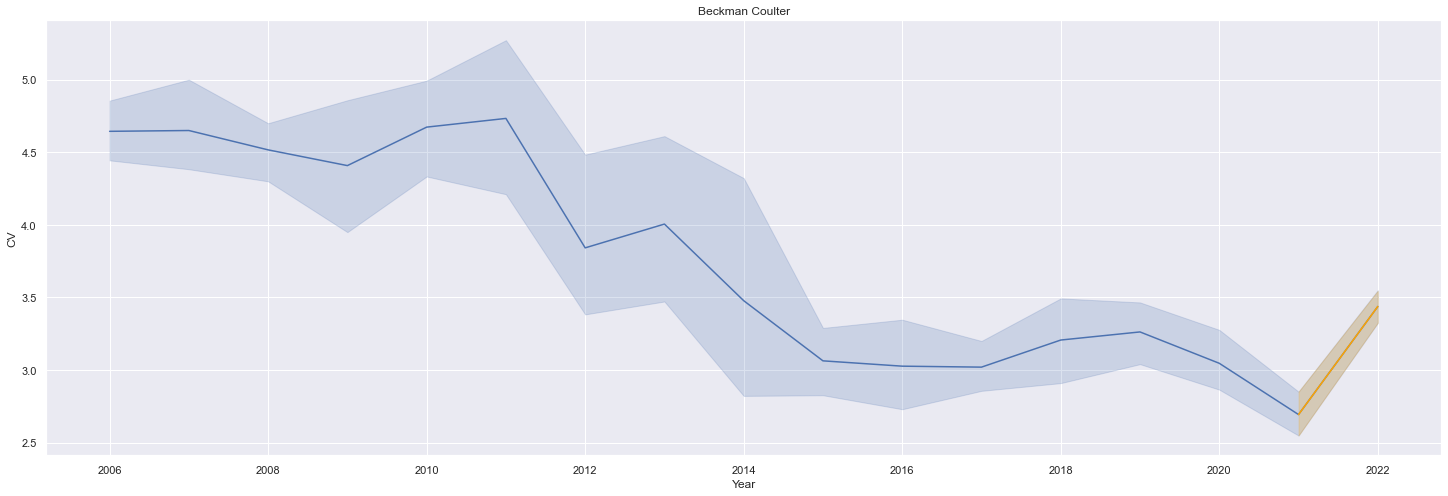

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                              2548.
Date:                Wed, 25 May 2022   Prob (F-statistic):                   7.99e-121
Time:                        14:36:00   Log-Likelihood:                         -239.33
No. Observations:                 215   AIC:                                      480.7
Df Residuals:                     214   BIC:                                      484.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

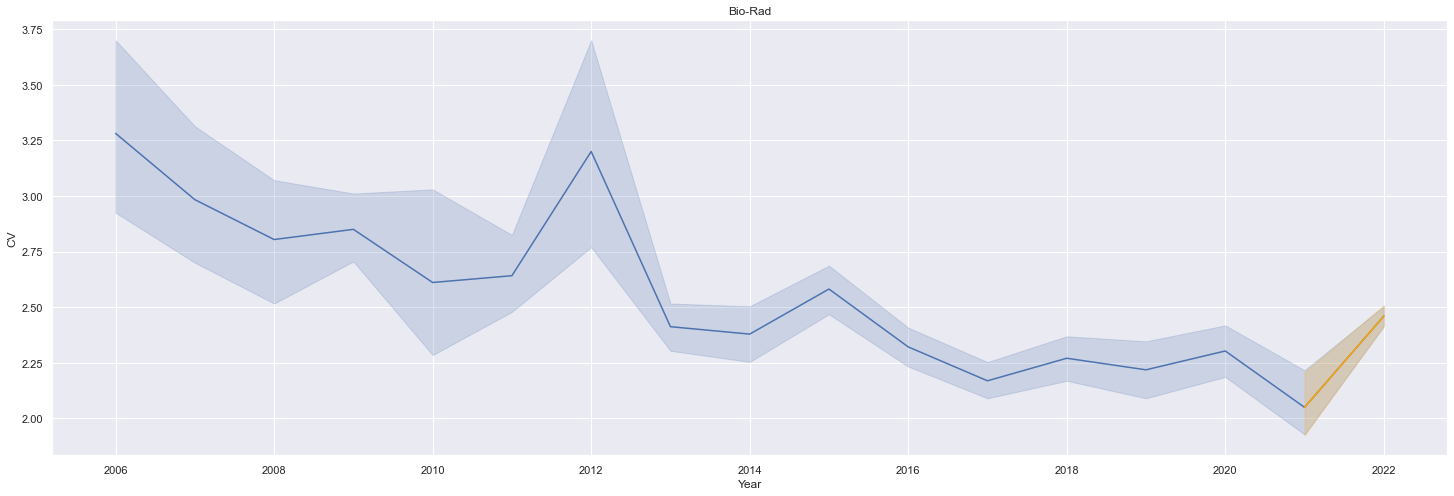

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.901
Model:                            OLS   Adj. R-squared (uncentered):              0.901
Method:                 Least Squares   F-statistic:                              1670.
Date:                Wed, 25 May 2022   Prob (F-statistic):                    6.22e-94
Time:                        14:36:00   Log-Likelihood:                         -243.32
No. Observations:                 184   AIC:                                      488.6
Df Residuals:                     183   BIC:                                      491.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

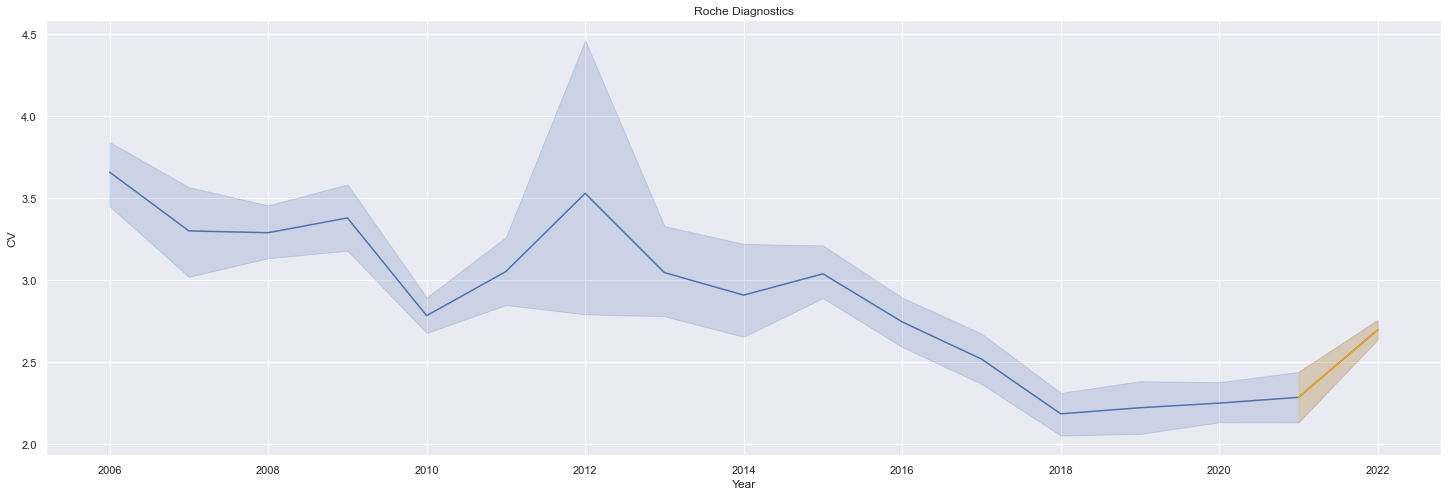

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              846.3
Date:                Wed, 25 May 2022   Prob (F-statistic):                    1.85e-29
Time:                        14:36:01   Log-Likelihood:                         -20.796
No. Observations:                  43   AIC:                                      43.59
Df Residuals:                      42   BIC:                                      45.35
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

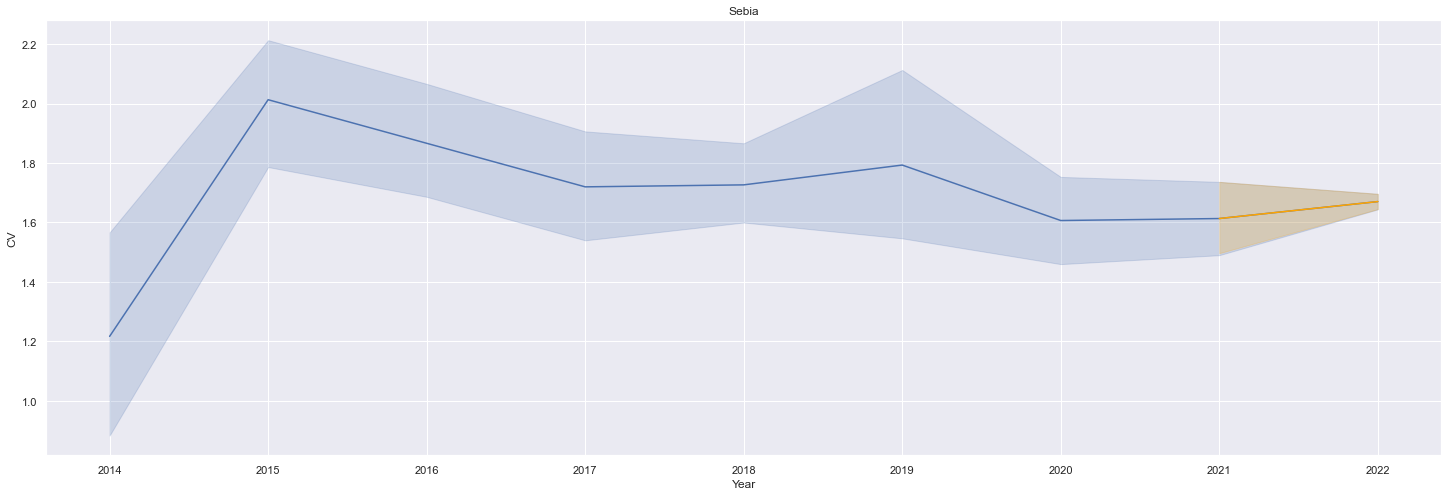

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                              4875.
Date:                Wed, 25 May 2022   Prob (F-statistic):                   3.89e-176
Time:                        14:36:01   Log-Likelihood:                         -298.57
No. Observations:                 274   AIC:                                      599.1
Df Residuals:                     273   BIC:                                      602.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

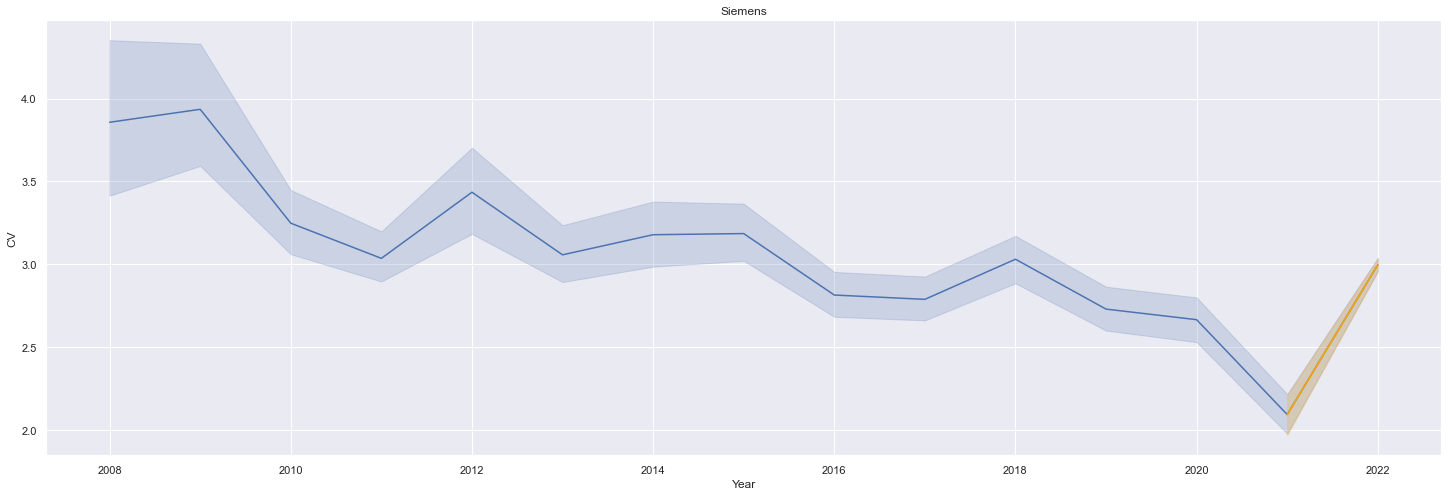

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.944
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              1392.
Date:                Wed, 25 May 2022   Prob (F-statistic):                    1.22e-53
Time:                        14:36:02   Log-Likelihood:                         -52.019
No. Observations:                  84   AIC:                                      106.0
Df Residuals:                      83   BIC:                                      108.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

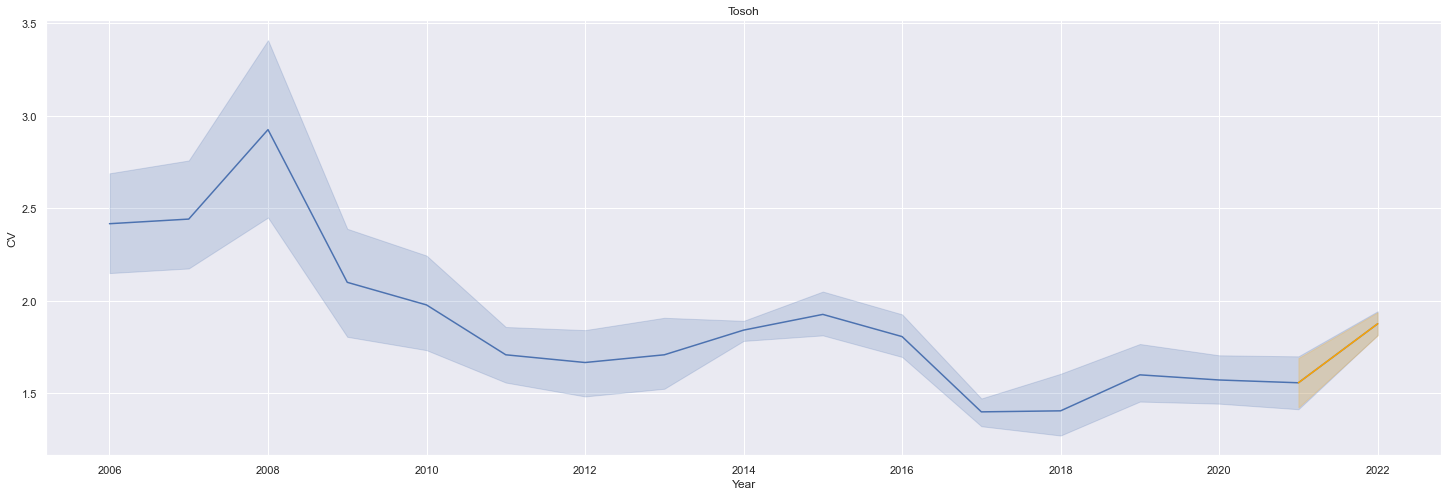

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              1466.
Date:                Wed, 25 May 2022   Prob (F-statistic):                    1.03e-38
Time:                        14:36:03   Log-Likelihood:                         -27.939
No. Observations:                  51   AIC:                                      57.88
Df Residuals:                      50   BIC:                                      59.81
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

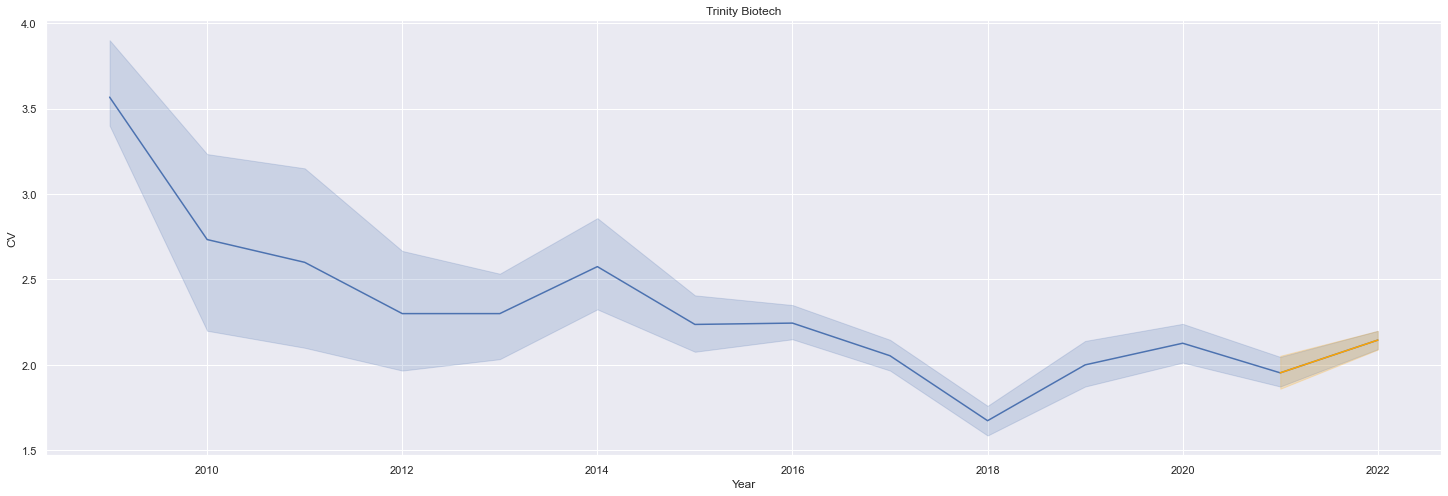

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              1396.
Date:                Wed, 25 May 2022   Prob (F-statistic):                    3.84e-37
Time:                        14:36:03   Log-Likelihood:                         -38.952
No. Observations:                  49   AIC:                                      79.90
Df Residuals:                      48   BIC:                                      81.80
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

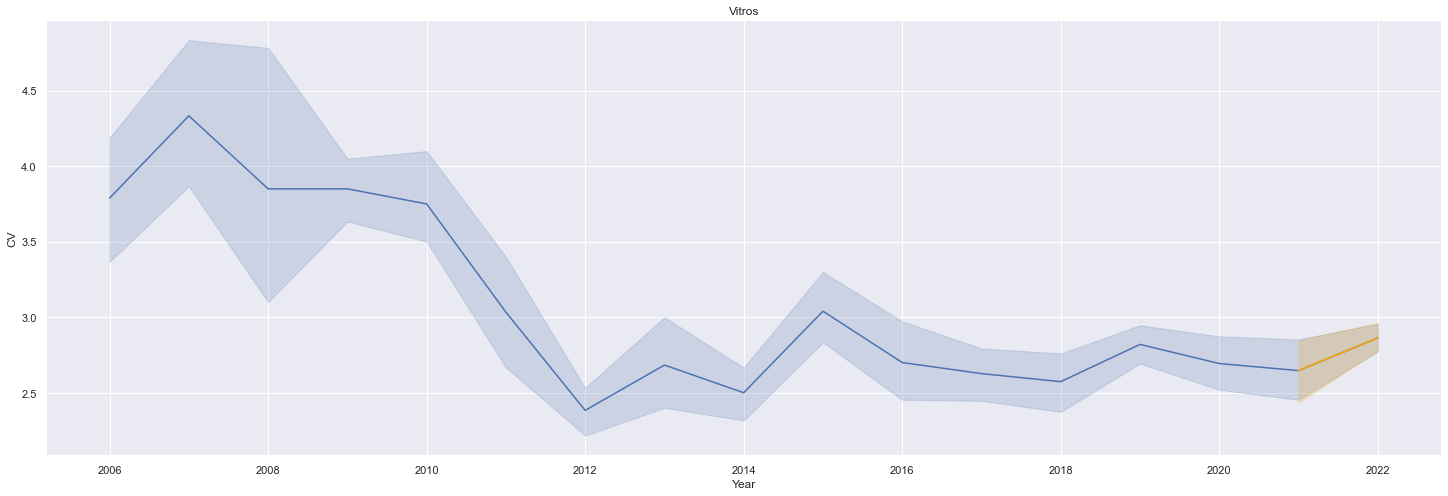

In [6]:
for name, data in manufacturerGroups:
    tempdf = data[['Year', 'CV']].dropna()

    X = tempdf.iloc[:, :-1].values
    Y = tempdf.iloc[:, 1].values

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

    from sklearn.linear_model import LinearRegression
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)

    preddf = pd.DataFrame(y_pred, columns=['CV'])
    preddf['Year'] = "2022"

    from statsmodels.api import OLS
    print(OLS(y_test,y_pred).fit().summary())

    # Add tempdf and preddf together and reset index
    tempdf = pd.concat([tempdf, preddf], axis=0, ignore_index=True)

    # Set the correct type 
    tempdf = tempdf.astype({'Year': 'int32'})

    sns.set(rc = {'figure.figsize':(25,8)})
    l = sns.lineplot(x='Year', y='CV', data=tempdf)
    l.set_title(name)
    sns.lineplot(x='Year', y='CV', data=tempdf[(tempdf['Year'] >= 2021) & (tempdf['Year'] <= 2022)], color='orange')
    plt.show()
    

# Conclusie

Zoals je ziet gaan alle voorspellingen weer omhoog. Dit komt omdat door alle jaren heen de CV waarde geleidelijk naar beneden is gegaan, maar in 2021 een hele dip maakte naar beneden. Om dit te corrigeren, heeft de liniare regressie de lijn weer omhoog getrokken om dit weer tot een goed werkend model te verkrijgen.

# Advies

Mijn advies is om te kijken in 2022 de CV waarde inderdaad omhoog gaat tegenover 2021.